# 教程二：迁移学习 - 从MNIST到USPS

First, we import the necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Set up matplotlib for visualizing loss curve

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plot_loss_curve(nepochs, test_losses, accuracies, plot_name):
    plt.title(plot_name)
    plt.xticks(np.arange(0, nepochs, 1))
    plt.gca().set_ylim([0, 1.6])
    plt.plot(range(nepochs), test_losses, 'r--', label='Loss')
    plt.plot(range(nepochs), accuracies, 'b', label='Accuracy')
    plt.legend()

Define model structure

In [3]:
# Define our own CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

Set up model and optimizer. First we train the model without any transfer learning, to see how well it does.

In [4]:
model = CNN()

import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Load train and test data

In [5]:
from dataset.usps import USPS
from torchvision import transforms

pre_process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(
                                  mean=(0.5, 0.5, 0.5),
                                  std=(0.5, 0.5, 0.5))])

usps_dataset_train = USPS(root="data",
                    train=True,
                    transform=pre_process,
                    download=True)

train_loader = torch.utils.data.DataLoader(
                    dataset=usps_dataset_train,
                    batch_size=64,
                    shuffle=True)

usps_dataset_test = USPS(root="data",
                    train=False,
                    transform=pre_process,
                    download=True)

test_loader = torch.utils.data.DataLoader(
                    dataset=usps_dataset_test,
                    batch_size=1000,
                    shuffle=True)

Method for training the model

In [6]:
from IPython.display import clear_output
def train(epoch, model, optimizer):
    model.train()
    num_batches = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.reshape(-1)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), float(loss)), end='\r')
        num_batches += 1
    torch.save(model.state_dict(), 'checkpoints/usps_%s.pth' % (epoch, ))

Method for testing the model

In [7]:
def test(epoch, model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        target = target.reshape(-1)
        with torch.no_grad():
            output = model(data)
            test_loss += float(F.nll_loss(output, target, size_average=False)) # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += int(pred.eq(target.data.view_as(pred)).long().sum())

    test_loss /= len(test_loader.dataset)
    accuracy = correct * 1.0 / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))
    
    return test_loss, accuracy

Train and test the model for a few epochs

Train Epoch: 0 [1624/7438 (99%)]	Loss: 2.163541
Test set: Average loss: 2.0929, Accuracy: 572/1860 (31%)

Train Epoch: 1 [1624/7438 (99%)]	Loss: 0.796093
Test set: Average loss: 0.7584, Accuracy: 1392/1860 (75%)

Train Epoch: 2 [1624/7438 (99%)]	Loss: 0.106264
Test set: Average loss: 0.3931, Accuracy: 1630/1860 (88%)

Train Epoch: 3 [1624/7438 (99%)]	Loss: 0.137748
Test set: Average loss: 0.3016, Accuracy: 1690/1860 (91%)

Train Epoch: 4 [1624/7438 (99%)]	Loss: 0.127993
Test set: Average loss: 0.2425, Accuracy: 1722/1860 (93%)

Train Epoch: 5 [1624/7438 (99%)]	Loss: 0.039456
Test set: Average loss: 0.2126, Accuracy: 1732/1860 (93%)

Train Epoch: 6 [1624/7438 (99%)]	Loss: 0.341555
Test set: Average loss: 0.2131, Accuracy: 1753/1860 (94%)

Train Epoch: 7 [1624/7438 (99%)]	Loss: 0.184891
Test set: Average loss: 0.1943, Accuracy: 1745/1860 (94%)

Train Epoch: 8 [1624/7438 (99%)]	Loss: 0.043327
Test set: Average loss: 0.1602, Accuracy: 1769/1860 (95%)

Train Epoch: 9 [1624/7438 (99%)]	Loss:

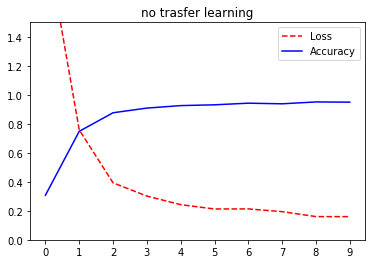

In [8]:
test_losses = []
accuracies = []
for epoch in range(10):
    train(epoch, model, optimizer)
    test_loss, accuracy = test(epoch, model)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
plot_loss_curve(10, test_losses, accuracies, 'no trasfer learning')

In [10]:
# Now, let's see what will happen if we reuse the pretrained MNIST model, and only replace the last layer

pretrained_model_path = 'mnist_models/mnist.pth'
model = CNN()
model.load_state_dict(torch.load(pretrained_model_path))

model.fc2 = nn.Linear(50, 10) # Only replace the last layer

optimizer = optim.SGD(model.fc2.parameters(), lr=0.01, momentum=0.5)

'''
layers_to_tune = model

if fine_tuning_on_mnist in ['last-layer', 'all-layers']:
    pretrained_model_path = 'mnist_models/mnist.pth'
    model.load_state_dict(torch.load(pretrained_model_path))

    if fine_tuning_on_mnist == 'last-layer':
        # Replace the last layer with a new uninitiated one, and only tune the parameters for this layer
        model.fc2 = nn.Linear(50, 10)
        layers_to_tune = model.fc2

import torch.optim as optim
optimizer = optim.SGD(layers_to_tune.parameters(), lr=0.01, momentum=0.5)
'''

"\nlayers_to_tune = model\n\nif fine_tuning_on_mnist in ['last-layer', 'all-layers']:\n    pretrained_model_path = 'mnist_models/mnist.pth'\n    model.load_state_dict(torch.load(pretrained_model_path))\n\n    if fine_tuning_on_mnist == 'last-layer':\n        # Replace the last layer with a new uninitiated one, and only tune the parameters for this layer\n        model.fc2 = nn.Linear(50, 10)\n        layers_to_tune = model.fc2\n\nimport torch.optim as optim\noptimizer = optim.SGD(layers_to_tune.parameters(), lr=0.01, momentum=0.5)\n"

Train Epoch: 0 [1624/7438 (99%)]	Loss: 0.199351
Test set: Average loss: 0.2191, Accuracy: 1746/1860 (94%)

Train Epoch: 1 [1624/7438 (99%)]	Loss: 0.049367
Test set: Average loss: 0.1766, Accuracy: 1766/1860 (95%)

Train Epoch: 2 [1624/7438 (99%)]	Loss: 0.145520
Test set: Average loss: 0.1584, Accuracy: 1778/1860 (96%)

Train Epoch: 3 [1624/7438 (99%)]	Loss: 0.041671
Test set: Average loss: 0.1484, Accuracy: 1771/1860 (95%)

Train Epoch: 4 [1624/7438 (99%)]	Loss: 0.279417
Test set: Average loss: 0.1488, Accuracy: 1777/1860 (96%)

Train Epoch: 5 [1624/7438 (99%)]	Loss: 0.169300
Test set: Average loss: 0.1393, Accuracy: 1781/1860 (96%)

Train Epoch: 6 [1624/7438 (99%)]	Loss: 0.032223
Test set: Average loss: 0.1374, Accuracy: 1790/1860 (96%)

Train Epoch: 7 [1624/7438 (99%)]	Loss: 0.041371
Test set: Average loss: 0.1287, Accuracy: 1787/1860 (96%)

Train Epoch: 8 [1624/7438 (99%)]	Loss: 0.009620
Test set: Average loss: 0.1307, Accuracy: 1786/1860 (96%)

Train Epoch: 9 [1624/7438 (99%)]	Loss

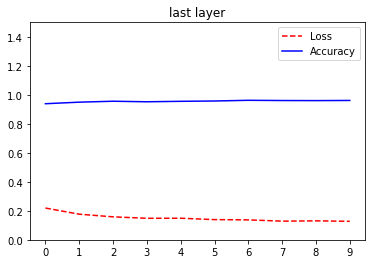

In [11]:
test_losses = []
accuracies = []
for epoch in range(10):
    train(epoch, model, optimizer)
    test_loss, accuracy = test(epoch, model)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
plot_loss_curve(10, test_losses, accuracies, 'last layer')

In [13]:
# Now, let's see what will happen if we reuse the pretrained MNIST model, but then fine-tune the whole model

pretrained_model_path = 'mnist_models/mnist.pth'
model = CNN()
model.load_state_dict(torch.load(pretrained_model_path))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Train Epoch: 0 [1624/7438 (99%)]	Loss: 0.046184
Test set: Average loss: 0.1095, Accuracy: 1800/1860 (97%)

Train Epoch: 1 [1624/7438 (99%)]	Loss: 0.146399
Test set: Average loss: 0.1408, Accuracy: 1779/1860 (96%)

Train Epoch: 2 [1624/7438 (99%)]	Loss: 0.004781
Test set: Average loss: 0.0912, Accuracy: 1813/1860 (97%)

Train Epoch: 3 [1624/7438 (99%)]	Loss: 0.013513
Test set: Average loss: 0.0762, Accuracy: 1815/1860 (98%)

Train Epoch: 4 [1624/7438 (99%)]	Loss: 0.358502
Test set: Average loss: 0.1011, Accuracy: 1800/1860 (97%)

Train Epoch: 5 [1624/7438 (99%)]	Loss: 0.112879
Test set: Average loss: 0.0901, Accuracy: 1805/1860 (97%)

Train Epoch: 6 [1624/7438 (99%)]	Loss: 0.071988
Test set: Average loss: 0.0945, Accuracy: 1805/1860 (97%)

Train Epoch: 7 [1624/7438 (99%)]	Loss: 0.002178
Test set: Average loss: 0.0785, Accuracy: 1811/1860 (97%)

Train Epoch: 8 [1624/7438 (99%)]	Loss: 0.005888
Test set: Average loss: 0.0694, Accuracy: 1823/1860 (98%)

Train Epoch: 9 [1624/7438 (99%)]	Loss

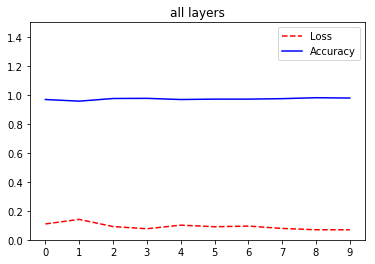

In [14]:
test_losses = []
accuracies = []
for epoch in range(10):
    train(epoch, model, optimizer)
    test_loss, accuracy = test(epoch, model)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
plot_loss_curve(10, test_losses, accuracies, 'all layers')

In [ ]:
# Comparing three three plots, we can see that training with pretrained MNIST model converges much faster,
# and all layers is better than last layer because the model can fit the new dataset better